<a href="https://colab.research.google.com/github/debashisdotchatterjee/Circular-Reliability-Paper-1/blob/main/Real_Data_on_Circular_Reliability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) statsmodels: El Niño monthly SST (NOAA)
import statsmodels.api as sm
eln = sm.datasets.elnino.load_pandas().data  # columns include 'YEAR', 'JAN', ... 'DEC'
# Melt to long format (month→angle), define events as SST > percentile per month, map to θ

# 2) statsmodels: Mauna Loa CO2 (weekly)
co2 = sm.datasets.co2.load_pandas().data  # 'co2' with a DatetimeIndex in older versions; else parse date
# Detrend (e.g., STL), mark positive anomalies above threshold as events, map day-of-year to θ

# 3) seaborn examples (requires internet for load_dataset)
import seaborn as sns
flights = sns.load_dataset("flights")       # month → phase; passengers as signal
# taxis = sns.load_dataset("taxis")         # pickup datetime → hour/day → phase (may require net)


<>:204: SyntaxWarning: invalid escape sequence '\m'
<>:204: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2031591556.py:204: SyntaxWarning: invalid escape sequence '\m'
  ax3.plot([mu_hat, mu_hat], [0, 1.05], lw=2.2, color='#22C55E', alpha=0.9, label='Center $\mu$')


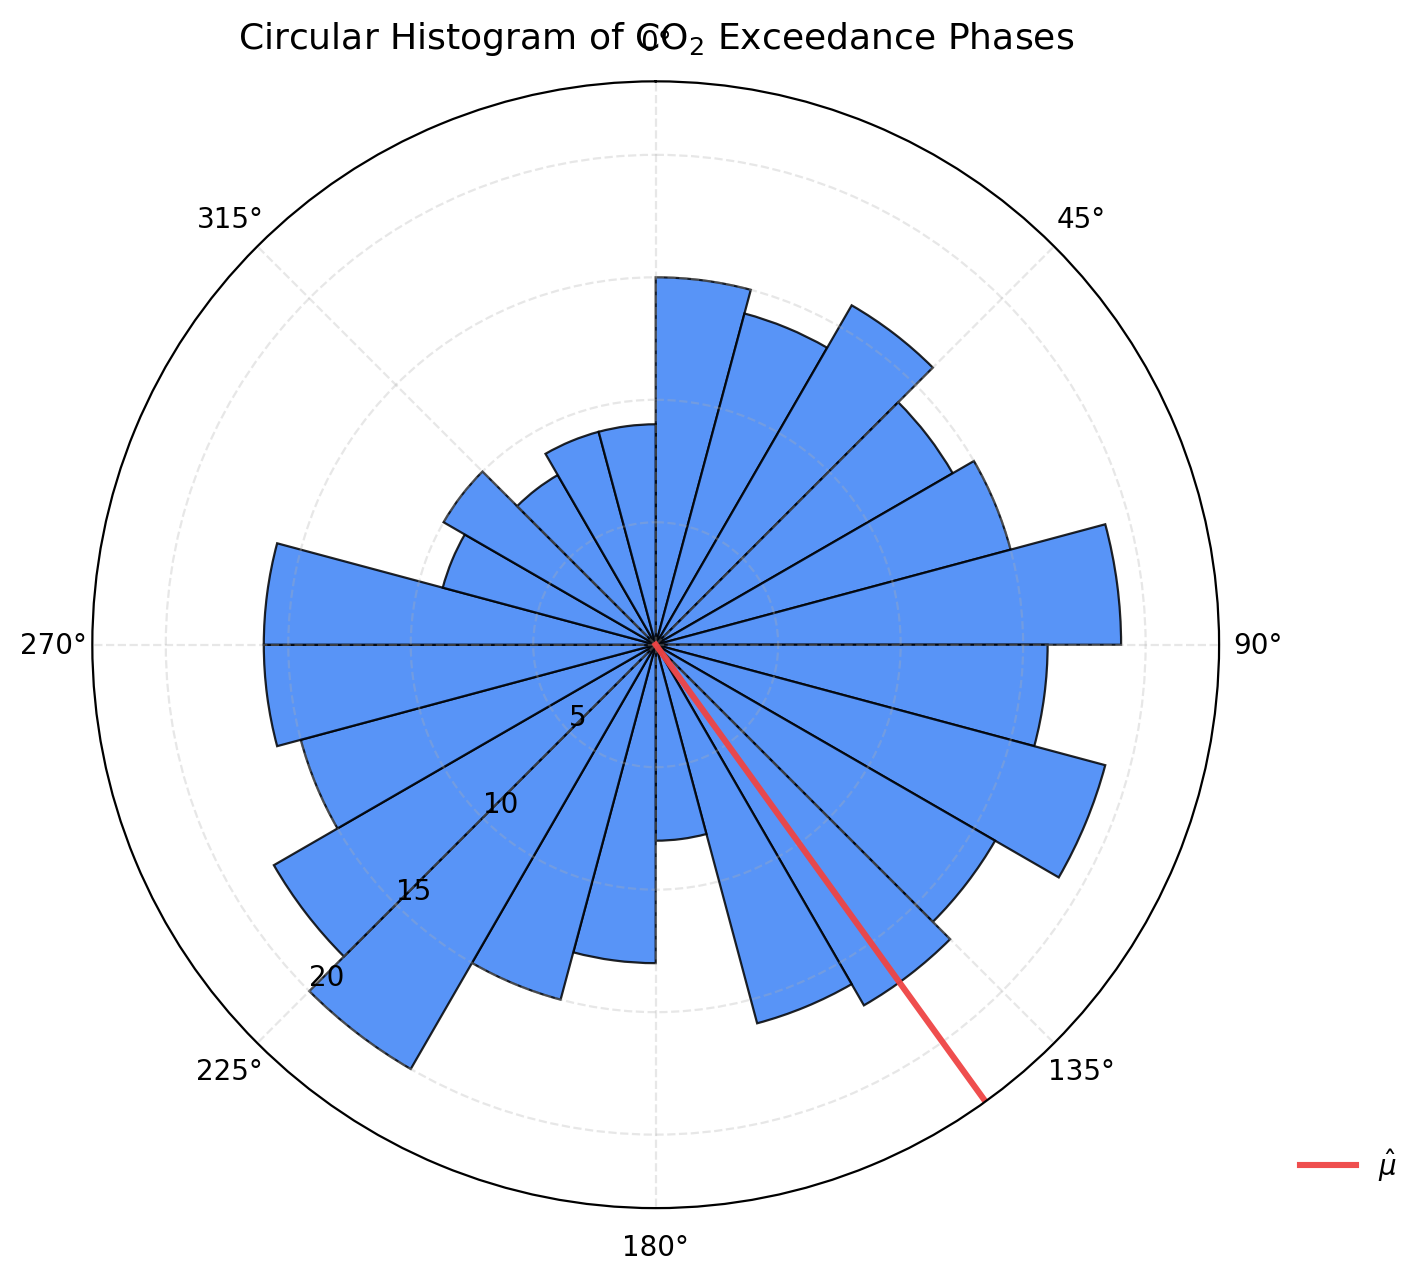

/tmp/ipython-input-2031591556.py:167: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f = f / (np.trapz(f, theta_grid))


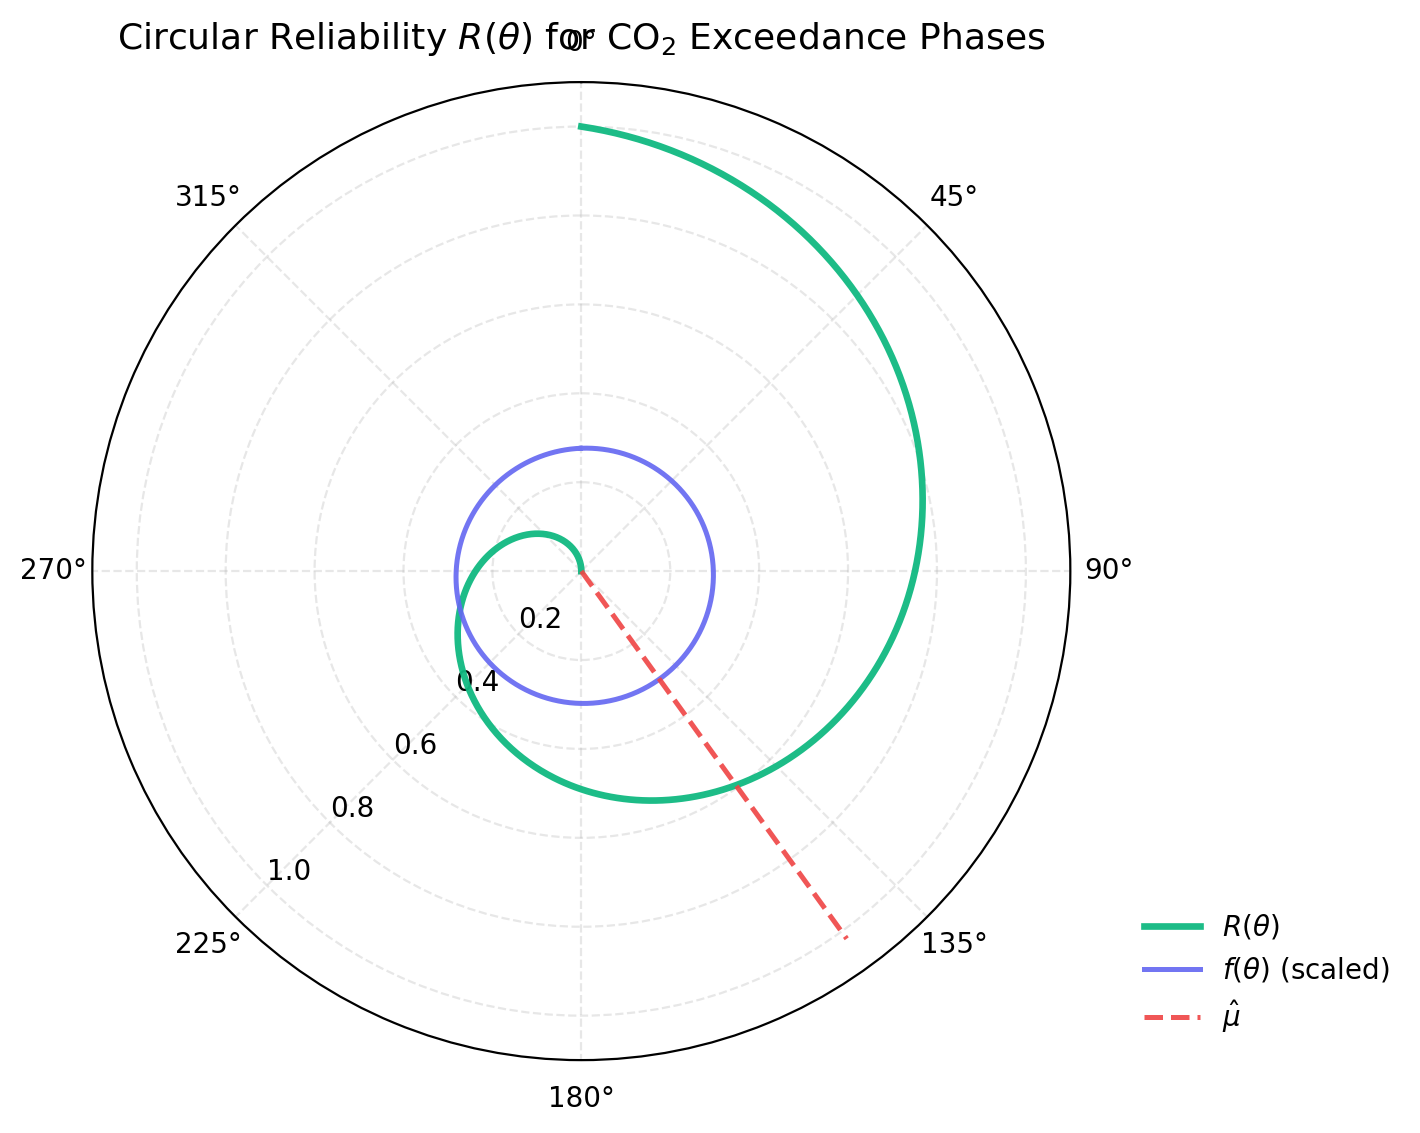

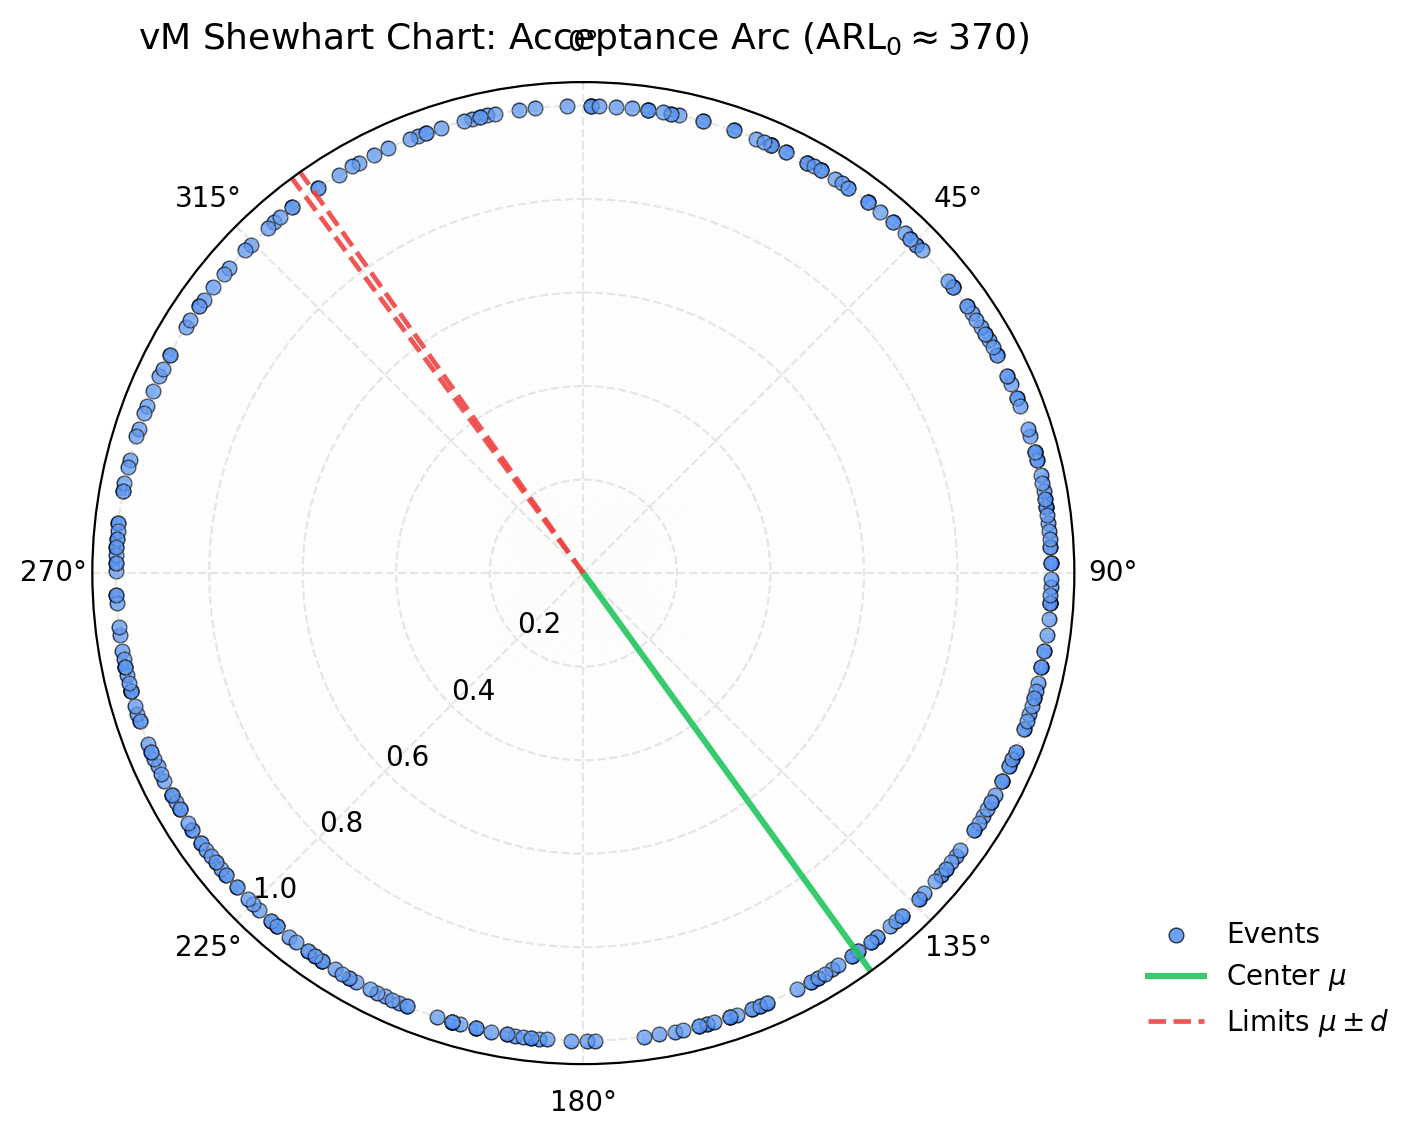

,metric,value
0,n_events,343
1,mean_direction_mu_rad,2.516309
2,mean_direction_day_of_year,147
3,mean_direction_calendar_month,May-27
4,resultant_length_Rbar,0.094737
5,kappa_hat,0.190331
6,Rayleigh_Z,3.078456
7,Rayleigh_pvalue,0.045919
8,alpha_target,0.002703
9,acceptance_halfwidth_d_rad,3.131172


,quantity,value
0,empirical_acceptance_prob,1.0
1,empirical_ARL0_est,inf


,co2,anomaly,doy,theta
1958-10-19,313.5,0.277377,292,5.026548
1958-10-26,313.5,0.291016,299,5.147048
1959-02-15,316.9,0.282299,46,0.791853
1959-04-26,318.3,0.863340,116,1.996848
1959-05-03,318.2,0.392264,123,2.117347
1959-09-06,314.4,0.312037,249,4.286337
1959-11-08,314.4,0.492650,312,5.370832
1959-11-15,314.8,0.613956,319,5.491332
1959-11-22,315.2,0.860230,326,5.611831
1959-12-13,315.6,0.266922,347,5.973330


Saved files:
 - circ_co2_outputs/co2_circ_hist.png
 - circ_co2_outputs/co2_circ_reliability.png
 - circ_co2_outputs/co2_acceptance_arc.png
 - circ_co2_outputs/summary_metrics.csv
 - circ_co2_outputs/arl0_estimates.csv
 - circ_co2_outputs/event_phases.csv
 - circ_co2_outputs.zip

Summary metrics:
                        metric     value
                     n_events       343
        mean_direction_mu_rad  2.516309
   mean_direction_day_of_year       147
mean_direction_calendar_month    May-27
        resultant_length_Rbar  0.094737
                    kappa_hat  0.190331
                   Rayleigh_Z  3.078456
              Rayleigh_pvalue  0.045919
                 alpha_target  0.002703
   acceptance_halfwidth_d_rad  3.131172

ARL0 estimates:
                  quantity  value
empirical_acceptance_prob    1.0
       empirical_ARL0_est    inf


In [3]:
# Re-running the full pipeline (the prior state was reset).
# See previous cell for detailed comments; this is a consolidated version that executes end-to-end.

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import i0, i1
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

# ---------------- Helpers ----------------

def circ_mean(thetas):
    C = np.mean(np.cos(thetas))
    S = np.mean(np.sin(thetas))
    return np.arctan2(S, C) % (2*np.pi)

def circ_resultant_length(thetas):
    C = np.mean(np.cos(thetas))
    S = np.mean(np.sin(thetas))
    return np.hypot(C, S)

def A_of_kappa(kappa):
    return i1(kappa) / i0(kappa)

def invert_A(R):
    R = float(np.clip(R, 1e-8, 0.999999))
    if R < 0.53:
        kappa0 = 2*R + R**3 + 5*R**5/6
    elif R < 0.85:
        kappa0 = -0.4 + 1.39*R + 0.43/(1-R)
    else:
        kappa0 = 1/(R**3 - 4*R**2 + 3*R)
    kappa = max(kappa0, 1e-6)
    for _ in range(60):
        Ak = A_of_kappa(kappa)
        dAk = 1 - Ak**2 - (Ak / max(kappa, 1e-9))
        step = (Ak - R) / max(dAk, 1e-9)
        kappa -= step
        if abs(step) < 1e-8:
            break
    return max(float(kappa), 1e-6)

def rayleigh_test(thetas):
    n = len(thetas)
    C = np.sum(np.cos(thetas))
    S = np.sum(np.sin(thetas))
    R = np.sqrt(C**2 + S**2) / n
    Z = n * R**2
    p = np.exp(-Z) * (1 + (2*Z - Z**2)/(4*n) - (24*Z - 132*Z**2 + 76*Z**3 - 9*Z**4)/(288*n**2))
    return Z, float(np.clip(p, 0.0, 1.0)), R

def circular_kde_vm(theta_grid, thetas, kappa=4.0):
    diffs = theta_grid[:, None] - thetas[None, :]
    kern = np.exp(kappa * np.cos(diffs)) / (2*np.pi * i0(kappa))
    return kern.mean(axis=1)

def choose_kappa_kde(thetas):
    Rbar = circ_resultant_length(thetas)
    if Rbar < 0.53:
        kappa = 2*Rbar + Rbar**3 + 5*Rbar**5/6
    elif Rbar < 0.85:
        kappa = -0.4 + 1.39*Rbar + 0.43/(1 - Rbar)
    else:
        kappa = 1/(Rbar**3 - 4*Rbar**2 + 3*Rbar)
    return max(kappa*0.7, 0.5)

def arl0_target_arc(mu, kappa, alpha=1/370, grid=30000, seed=7):
    rng = np.random.default_rng(seed)
    samples = rng.vonmises(mu=mu, kappa=kappa, size=grid)
    lo, hi = 0.0, np.pi
    for _ in range(40):
        mid = 0.5*(lo+hi)
        acc = np.mean(np.abs(((samples - mu + np.pi) % (2*np.pi)) - np.pi) <= mid)
        if acc >= 1 - alpha:
            hi = mid
        else:
            lo = mid
    return 0.5*(lo+hi)

# ---------------- Data ----------------

df = sm.datasets.co2.load_pandas().data.copy()
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
else:
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors='coerce')
df = df[['co2']].dropna()
df = df.asfreq('W', method='pad')

# STL
stl = STL(df['co2'], period=52, robust=True)
res = stl.fit()
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid
df['anomaly'] = df['co2'] - (df['trend'] + df['seasonal'])

# events
thr = df['anomaly'].quantile(0.85)
ev = df[df['anomaly'] > thr].copy()
ev['doy'] = ev.index.dayofyear
ev['theta'] = (2*np.pi * (ev['doy'] % 365) / 365.0).values
if len(ev) < 30:
    thr = df['anomaly'].quantile(0.75)
    ev = df[df['anomaly'] > thr].copy()
    ev['doy'] = ev.index.dayofyear
    ev['theta'] = (2*np.pi * (ev['doy'] % 365) / 365.0).values

thetas = ev['theta'].to_numpy() % (2*np.pi)

# circular stats
mu_hat = circ_mean(thetas)
Z, p_rayleigh, Rbar = rayleigh_test(thetas)
kappa_hat = invert_A(Rbar)

mu_day = int((mu_hat/(2*np.pi))*365) + 1
mu_month = (pd.Timestamp('2001-01-01') + pd.Timedelta(days=mu_day-1)).strftime('%b-%d')

alpha = 1/370
d_star = arl0_target_arc(mu_hat, kappa_hat, alpha=alpha, grid=30000, seed=7)

# ---------------- Plots ----------------

out_dir = "circ_co2_outputs"
os.makedirs(out_dir, exist_ok=True)

def polar_setup(ax):
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(225)
    ax.grid(True, alpha=0.3, linestyle='--')

# 1) Histogram
bins = np.linspace(0, 2*np.pi, 25)
counts, _ = np.histogram(thetas, bins=bins)
centers = (bins[:-1] + bins[1:]) / 2
widths = np.diff(bins)

fig1 = plt.figure(figsize=(7.2,7.2), dpi=200)
ax1 = fig1.add_subplot(111, projection='polar')
polar_setup(ax1)
bars = ax1.bar(centers, counts, width=widths, align='center',
               linewidth=0.8, edgecolor='black', color='#3B82F6', alpha=0.85)
rmax = counts.max()*1.15 if counts.max()>0 else 1.0
ax1.plot([mu_hat, mu_hat], [0, rmax], lw=2.2, color='#EF4444', alpha=0.95, label=r'$\hat{\mu}$')
ax1.set_rlim(0, rmax if rmax>0 else 1.0)
ax1.set_title("Circular Histogram of CO$_2$ Exceedance Phases", pad=12, fontsize=13)
ax1.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), frameon=False)
fig1.tight_layout()
hist_png = os.path.join(out_dir, "co2_circ_hist.png")
hist_pdf = os.path.join(out_dir, "co2_circ_hist.pdf")
fig1.savefig(hist_png, dpi=300, bbox_inches='tight')
fig1.savefig(hist_pdf, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig1)

# 2) Reliability
grid = 720
theta_grid = np.linspace(0, 2*np.pi, grid, endpoint=False)
kappa_kde = choose_kappa_kde(thetas)
f = circular_kde_vm(theta_grid, thetas, kappa=kappa_kde)
f = f / (np.trapz(f, theta_grid))
F = np.cumsum((f[:-1]+f[1:])/2) * (theta_grid[1]-theta_grid[0])
F = np.concatenate([[0.0], F])
F = F / (F[-1] if F[-1]!=0 else 1.0)
R = 1.0 - F
Rmax = float(np.max(R)) if np.max(R)>0 else 1.0
density_scaled = (f / f.max()) * (0.3 * Rmax)

fig2 = plt.figure(figsize=(7.2,7.2), dpi=200)
ax2 = fig2.add_subplot(111, projection='polar')
polar_setup(ax2)
ax2.plot(theta_grid, R, lw=2.4, color='#10B981', alpha=0.95, label=r'$R(\theta)$')
ax2.plot(theta_grid, density_scaled, lw=1.8, color='#6366F1', alpha=0.9, label=r'$f(\theta)$ (scaled)')
ax2.plot([mu_hat, mu_hat], [0, Rmax*1.02], lw=1.8, color='#EF4444', alpha=0.9, linestyle='--', label=r'$\hat{\mu}$')
ax2.set_rlim(0, max(1.0, Rmax*1.1))
ax2.set_title("Circular Reliability $R(\\theta)$ for CO$_2$ Exceedance Phases", pad=12, fontsize=13)
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), frameon=False)
fig2.tight_layout()
rel_png = os.path.join(out_dir, "co2_circ_reliability.png")
rel_pdf = os.path.join(out_dir, "co2_circ_reliability.pdf")
fig2.savefig(rel_png, dpi=300, bbox_inches='tight')
fig2.savefig(rel_pdf, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig2)

# 3) Acceptance arc
fig3 = plt.figure(figsize=(7.2,7.2), dpi=200)
ax3 = fig3.add_subplot(111, projection='polar')
polar_setup(ax3)
ax3.scatter(thetas, np.ones_like(thetas), s=28, c='#3B82F6', alpha=0.75, edgecolors='black', linewidths=0.5, label='Events')

lower = (mu_hat - d_star) % (2*np.pi)
upper = (mu_hat + d_star) % (2*np.pi)
angs = np.linspace(mu_hat - d_star, mu_hat + d_star, 200)
rr = np.linspace(0, 1, 50)
ANG, RR = np.meshgrid(angs, rr)
pc = ax3.pcolormesh(ANG, RR, np.ones_like(ANG), cmap='Greens', alpha=0.15, shading='auto')
ax3.plot([mu_hat, mu_hat], [0, 1.05], lw=2.2, color='#22C55E', alpha=0.9, label='Center $\mu$')
ax3.plot([lower, lower], [0, 1.05], lw=1.7, color='#EF4444', linestyle='--', alpha=0.9, label=r'Limits $\mu\pm d$')
ax3.plot([upper, upper], [0, 1.05], lw=1.7, color='#EF4444', linestyle='--', alpha=0.9)
ax3.set_rlim(0, 1.05)
ax3.set_title("vM Shewhart Chart: Acceptance Arc (ARL$_0\\approx$370)", pad=12, fontsize=13)
ax3.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), frameon=False)
fig3.tight_layout()
arc_png = os.path.join(out_dir, "co2_acceptance_arc.png")
arc_pdf = os.path.join(out_dir, "co2_acceptance_arc.pdf")
fig3.savefig(arc_png, dpi=300, bbox_inches='tight')
fig3.savefig(arc_pdf, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig3)

# ---------------- Tables ----------------

summary = pd.DataFrame({
    'metric': [
        'n_events', 'mean_direction_mu_rad', 'mean_direction_day_of_year',
        'mean_direction_calendar_month', 'resultant_length_Rbar', 'kappa_hat',
        'Rayleigh_Z', 'Rayleigh_pvalue', 'alpha_target', 'acceptance_halfwidth_d_rad'
    ],
    'value': [
        len(thetas), mu_hat, int((mu_hat/(2*np.pi))*365)+1, mu_month,
        Rbar, kappa_hat, Z, p_rayleigh, alpha, d_star
    ]
})

emp_accept = np.mean(np.abs(((thetas - mu_hat + np.pi) % (2*np.pi)) - np.pi) <= d_star)
arlexp = 1/(1-emp_accept) if (1-emp_accept)>0 else np.inf
arltab = pd.DataFrame({
    'quantity': ['empirical_acceptance_prob', 'empirical_ARL0_est'],
    'value': [emp_accept, arlexp]
})

events_out = ev[['co2', 'anomaly', 'doy', 'theta']].copy()

summary_csv = os.path.join(out_dir, "summary_metrics.csv")
arltab_csv  = os.path.join(out_dir, "arl0_estimates.csv")
events_csv  = os.path.join(out_dir, "event_phases.csv")

summary.to_csv(summary_csv, index=False)
arltab.to_csv(arltab_csv, index=False)
events_out.to_csv(events_csv, index=True)

# ---------------- Zip bundle ----------------
zip_path = "circ_co2_outputs.zip"
with zipfile.ZipFile(zip_path, mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    for f in [hist_png, hist_pdf, rel_png, rel_pdf, arc_png, arc_pdf, summary_csv, arltab_csv, events_csv]:
        zf.write(f, arcname=os.path.join("circ_co2_outputs", os.path.basename(f)))

# Show dataframes to user
display(summary)
display(arltab)
display(events_out.head(25))

print("Saved files:")
for f in [hist_png, rel_png, arc_png, summary_csv, arltab_csv, events_csv, zip_path]:
    print(" -", f)

print("\nSummary metrics:\n", summary.to_string(index=False))
print("\nARL0 estimates:\n", arltab.to_string(index=False))

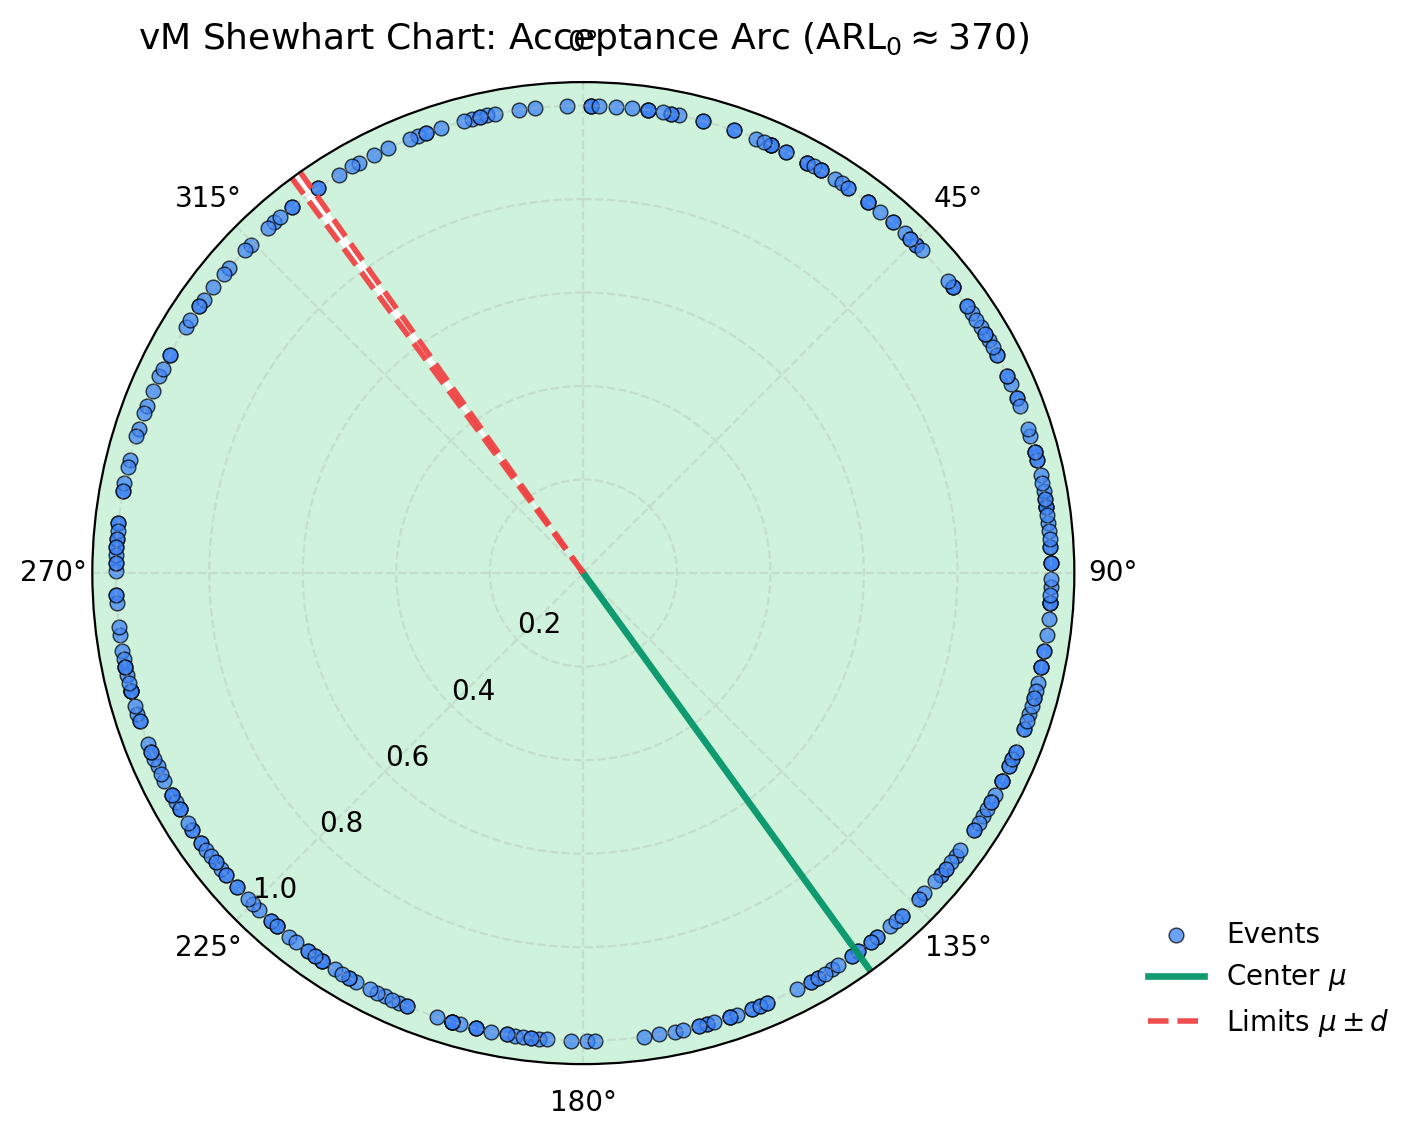

In [6]:
def fill_acceptance_region(ax, mu, d, rmax=1.05, color='#22C55E', alpha=0.22, zorder=0.5):
    """
    Shade the acceptance region {theta: |wrap(theta - mu)| <= d} on a polar axis.
    Handles wrap-around by splitting into at most two intervals.
    """
    mu = mu % (2*np.pi)
    lower = (mu - d) % (2*np.pi)
    upper = (mu + d) % (2*np.pi)
    N = 720

    def _fill(a, b):
        angs = np.linspace(a, b, N)
        ax.fill_between(angs, 0.0, rmax, color=color, alpha=alpha, zorder=zorder, linewidth=0)

    if lower <= upper:
        _fill(lower, upper)
    else:
        # wraps around 2π: [0, upper] ∪ [lower, 2π]
        _fill(0.0, upper)
        _fill(lower, 2*np.pi)

# Usage in your plotting code:
fig3 = plt.figure(figsize=(7.2,7.2), dpi=200)
ax = fig3.add_subplot(111, projection='polar')
polar_setup(ax) # polar_setup is defined in the previous cell
fill_acceptance_region(ax, mu_hat, d_star, rmax=1.05, color='#22C55E', alpha=0.22, zorder=0.2)
ax.scatter(thetas, np.ones_like(thetas), s=28, c='#3B82F6',
           alpha=0.75, edgecolors='black', linewidths=0.5, label='Events', zorder=1.5)
ax.plot([mu_hat, mu_hat], [0, 1.05], lw=2.4, color='#059669', alpha=0.95, label='Center $\\mu$', zorder=2.0)
ax.plot([(mu_hat - d_star)%(2*np.pi), (mu_hat - d_star)%(2*np.pi)], [0, 1.05],
        lw=2.0, color='#EF4444', linestyle='--', alpha=0.95, label=r'Limits $\mu \pm d$', zorder=2.0)
ax.plot([(mu_hat + d_star)%(2*np.pi), (mu_hat + d_star)%(2*np.pi)], [0, 1.05],
        lw=2.0, color='#EF4444', linestyle='--', alpha=0.95, zorder=2.0)
ax.set_rlim(0, 1.05)
ax.set_title("vM Shewhart Chart: Acceptance Arc (ARL$_0\\approx$370)", pad=12, fontsize=13)
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 0.0), frameon=False)
fig3.tight_layout()
out_dir = "circ_co2_outputs" # out_dir is defined in the previous cell
arc_png = os.path.join(out_dir, "co2_acceptance_arc.png")
arc_pdf = os.path.join(out_dir, "co2_acceptance_arc.pdf")
fig3.savefig(arc_png, dpi=300, bbox_inches='tight')
fig3.savefig(arc_pdf, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig3)